In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from difflib import get_close_matches
import pandas as pd
import numpy as np
# Load data
df = pd.read_csv("data/clean/cleaned_data.csv")

In [2]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[["genre", "author"]]).toarray()
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["genre", "author"]))

In [3]:
#features: genre + normalized rating
features = pd.concat([df[["average_rating", "publication_year"]].reset_index(drop=True), encoded_df], axis=1)

In [4]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
cosine_sim = cosine_similarity(scaled_features)

In [6]:
def recommend_books_cosine(title, df, cosine_sim, n=5, show_output=True):
    """
    Recommend books similar to the given title using cosine similarity.
    Works with pre-cleaned titles and avoids regex issues.
    """

    # Ensure title column is string type
    df["title"] = df["title"].astype(str)

    # Clean user input (lowercase and strip extra spaces)
    title_clean = title.strip().lower()

    # Step 1: Try partial match
    matches = df[df["title"].str.contains(title_clean, na=False, regex=False)]

    # Step 2: Fuzzy fallback (for typos or incomplete input)
    if matches.empty:
        close = get_close_matches(title_clean, df["title"], n=1, cutoff=0.4)
        if close:
            matches = df[df["title"] == close[0]]

    # Step 3: Handle no match case
    if matches.empty:
        if show_output:
            print(f"❌ No books found for '{title}'. Try another keyword.")
        return None

    # Step 4: Pick the best match automatically
    matched_idx = matches.index[0]
    matched_title = df.loc[matched_idx, "title"]

    # Step 5: Compute cosine similarity scores
    sim_scores = list(enumerate(cosine_sim[matched_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i for i, _ in sim_scores[1:n+1]]

    # Step 6: Get recommended books
    recs = df.iloc[sim_indices][["title", "author", "genre", "average_rating", "link"]]

    # Step 7: Display results (only in interactive mode)
    if show_output:
        print(f"\n🔹 **Searched Book:** {matched_title}")
        print(f"   Author: {df.loc[matched_idx, 'author']}")
        print(f"   Genre: {df.loc[matched_idx, 'genre']}")
        print(f"   Rating: {df.loc[matched_idx, 'average_rating']}\n")

        print(f"📚 **Top {n} Similar Books:**\n")
        for i, row in recs.iterrows():
            print(f"{i+1}. {row['title']} | {row['author']} | {row['genre']} | Rating: {row['average_rating']}")

    return recs

In [7]:
result = recommend_books_cosine("harry potter", df, cosine_sim, n=5)


🔹 **Searched Book:** harry potter and the philosophers stone harry potter 1
   Author: J.K. Rowling
   Genre: children
   Rating: 4.47

📚 **Top 5 Similar Books:**

18. harry potter and the order of the phoenix harry potter 5 | J.K. Rowling | children | Rating: 4.5
10. harry potter and the chamber of secrets harry potter 2 | J.K. Rowling | children | Rating: 4.43
15. harry potter and the goblet of fire harry potter 4 | J.K. Rowling | children | Rating: 4.57
12. harry potter and the prisoner of azkaban harry potter 3 | J.K. Rowling | children | Rating: 4.58
19. harry potter and the halfblood prince harry potter 6 | J.K. Rowling | children | Rating: 4.58


In [8]:
df["relevant"] = np.where(df["average_rating"] >= 4.0, 1, 0)

In [9]:
def precision_recall_at_k(model_func, df, cosine_sim, k=5):
    """
    Evaluate the recommender using Precision@k and Recall@k.
    Only displays overall averaged results.
    """
    precisions, recalls = [], []

    for _, row in df.iterrows():
        title = row["title"]
        recs = model_func(title, df, cosine_sim, n=k, show_output=False)

        # Skip if no recommendations returned
        if recs is None or recs.empty:
            continue

        # Ensure 'relevant' column is present
        if "relevant" not in recs.columns:
            recs = recs.merge(df[["title", "relevant"]], on="title", how="left")

        # Calculate Precision and Recall
        relevant_recs = recs["relevant"].sum()
        total_relevant = df["relevant"].sum()

        precision = relevant_recs / len(recs)
        recall = relevant_recs / total_relevant

        precisions.append(precision)
        recalls.append(recall)

    # Compute averages
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    print(f"✅ Precision@{k}: {avg_precision:.3f}")
    print(f"✅ Recall@{k}: {avg_recall:.3f}")

    return avg_precision, avg_recall

In [10]:
precision_recall_at_k(recommend_books_cosine, df, cosine_sim, k=3)

✅ Precision@3: 0.605
✅ Recall@3: 0.002


(0.6047269763651182, 0.0024221374220231703)

In [13]:
import matplotlib.pyplot as plt

def evaluate_precision_recall_vs_k(model_func, df, cosine_sim, k_values):
    precisions, recalls = [], []

    for k in k_values:
        p, r = precision_recall_at_k(model_func, df, cosine_sim, k)
        precisions.append(p)
        recalls.append(r)

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, precisions, marker='o', label='Precision@k', linewidth=2)
    plt.plot(k_values, recalls, marker='s', label='Recall@k', linewidth=2)
    plt.title('Precision vs Recall at Different k Values', fontsize=14)
    plt.xlabel('k (Number of Recommendations)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(k_values)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig("charts/evaluation.png", bbox_inches="tight", dpi=300)
    plt.show()

    return np.array(precisions), np.array(recalls)

✅ Precision@3: 0.605
✅ Recall@3: 0.002
✅ Precision@5: 0.602
✅ Recall@5: 0.004
✅ Precision@10: 0.578
✅ Recall@10: 0.008
✅ Precision@15: 0.589
✅ Recall@15: 0.012
✅ Precision@20: 0.604
✅ Recall@20: 0.016


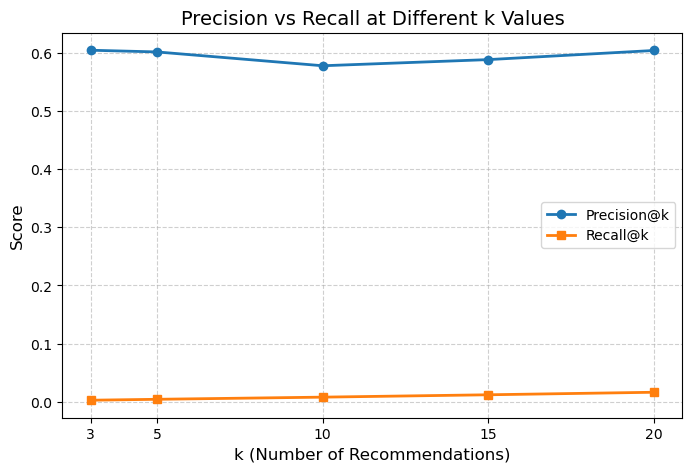

In [14]:
k_values = [3, 5, 10, 15, 20]
precisions, recalls = evaluate_precision_recall_vs_k(recommend_books_cosine, df, cosine_sim, k_values)